### Zadanie 14 — (5p)

Dla problemów **(a)** i **(b)** z Zadania 13 wybierz dwa ciągłe predyktory, które wydają się być istotne, i narysuj granice decyzyjne dla testowanych przez Ciebie modeli. Możesz oprzeć się na tym tutorialu. W punkcie **(b)** mamy do czynienia z więcej niż dwoma klasami, więc do generowania wykresów należy użyć więcej niż dwóch kolorów. Czy jesteś w stanie zaproponować sensowne granice decyzyjne dla problemu z punktu **(b)**?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from patsy import dmatrices, dmatrix

In [3]:
# Load the dataset
cards_df = pd.read_csv('Credit.csv')
# Set parameters as categorical
cards_df['Gender'] = cards_df['Gender'].astype('category')
cards_df['Student'] = cards_df['Student'].astype('category')
cards_df['Married'] = cards_df['Married'].astype('category')
cards_df['Ethnicity'] = cards_df['Ethnicity'].astype('category')

print(cards_df.shape)
# Display the first few rows of the dataframe
cards_df.head()

(400, 12)


,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [4]:
income_df = pd.read_csv('Credit.csv')

# Create a new indicator variable based on Income
income_df['HighIncome'] = (income_df['Income'] > 50).astype(int)

# Drop the original Income column
income_df.drop(columns=['Income'], inplace=True)

# Set parameters as categorical
income_df['Gender']     = income_df['Gender'].astype('category')
income_df['Student']    = income_df['Student'].astype('category')
income_df['Married']    = income_df['Married'].astype('category')
income_df['Ethnicity']  = income_df['Ethnicity'].astype('category')
# income_df['HighIncome'] = income_df['HighIncome'].astype('category')

print(income_df.shape)

income_df.head()

(400, 12)


,Unnamed: 0,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,HighIncome
0,1,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,2,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,3,7075,514,4,71,11,Male,No,No,Asian,580,1
3,4,9504,681,3,36,11,Female,No,No,Asian,964,1
4,5,4897,357,2,68,16,Male,No,Yes,Caucasian,331,1


In [5]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

In [6]:
models = []
models.append(('LRE ', LogisticRegression(max_iter=100000)))
models.append(('DTCGin', DecisionTreeClassifier(criterion='gini')))
models.append(('DTCEnt', DecisionTreeClassifier(criterion='entropy')))
models.append(('DTCLL', DecisionTreeClassifier(criterion='log_loss')))
models.append(('DTC3', DecisionTreeClassifier(max_depth=3)))
models.append(('DTC10', DecisionTreeClassifier(max_depth=10)))
models.append(('RFC3', RandomForestClassifier(max_depth=3)))
models.append(('RFC10', RandomForestClassifier(max_depth=10)))
models.append(('RFCn1', RandomForestClassifier(n_estimators=1)))
models.append(('RFCn4', RandomForestClassifier(n_estimators=4)))
models.append(('RFC', RandomForestClassifier()))
models.append(('KNN1', KNeighborsClassifier(n_neighbors=1)))
models.append(('KNN5', KNeighborsClassifier(n_neighbors=5)))

# models.append(('LRE ', LogisticRegression(max_iter=100000)))
# models.append(('DTCGin', DecisionTreeClassifier(criterion='gini')))
# models.append(('RFC3', RandomForestClassifier(max_depth=3)))
# models.append(('KNN1', KNeighborsClassifier(n_neighbors=1)))



In [7]:
datasets = []

income_model = 'HighIncome ~ Limit + Balance - 1'
cards_model  = 'Cards      ~ Income + Rating - 1'

y, x = dmatrices(income_model, data=income_df, return_type='dataframe')
Y = y.values.ravel()
X = x.values
datasets.append((Y, X))

print("Income model")
print(Y.shape, X.shape)

y, x = dmatrices(cards_model, data=cards_df, return_type='dataframe')
Y = y.values.ravel()
X = x.values
# X = x.values[:, 1:]  # Remove the first dimension (intercept)
datasets.append((Y, X))

print("Cards model")
print(Y.shape, X.shape)

Income model
(400,) (400, 2)
Cards model
(400,) (400, 2)


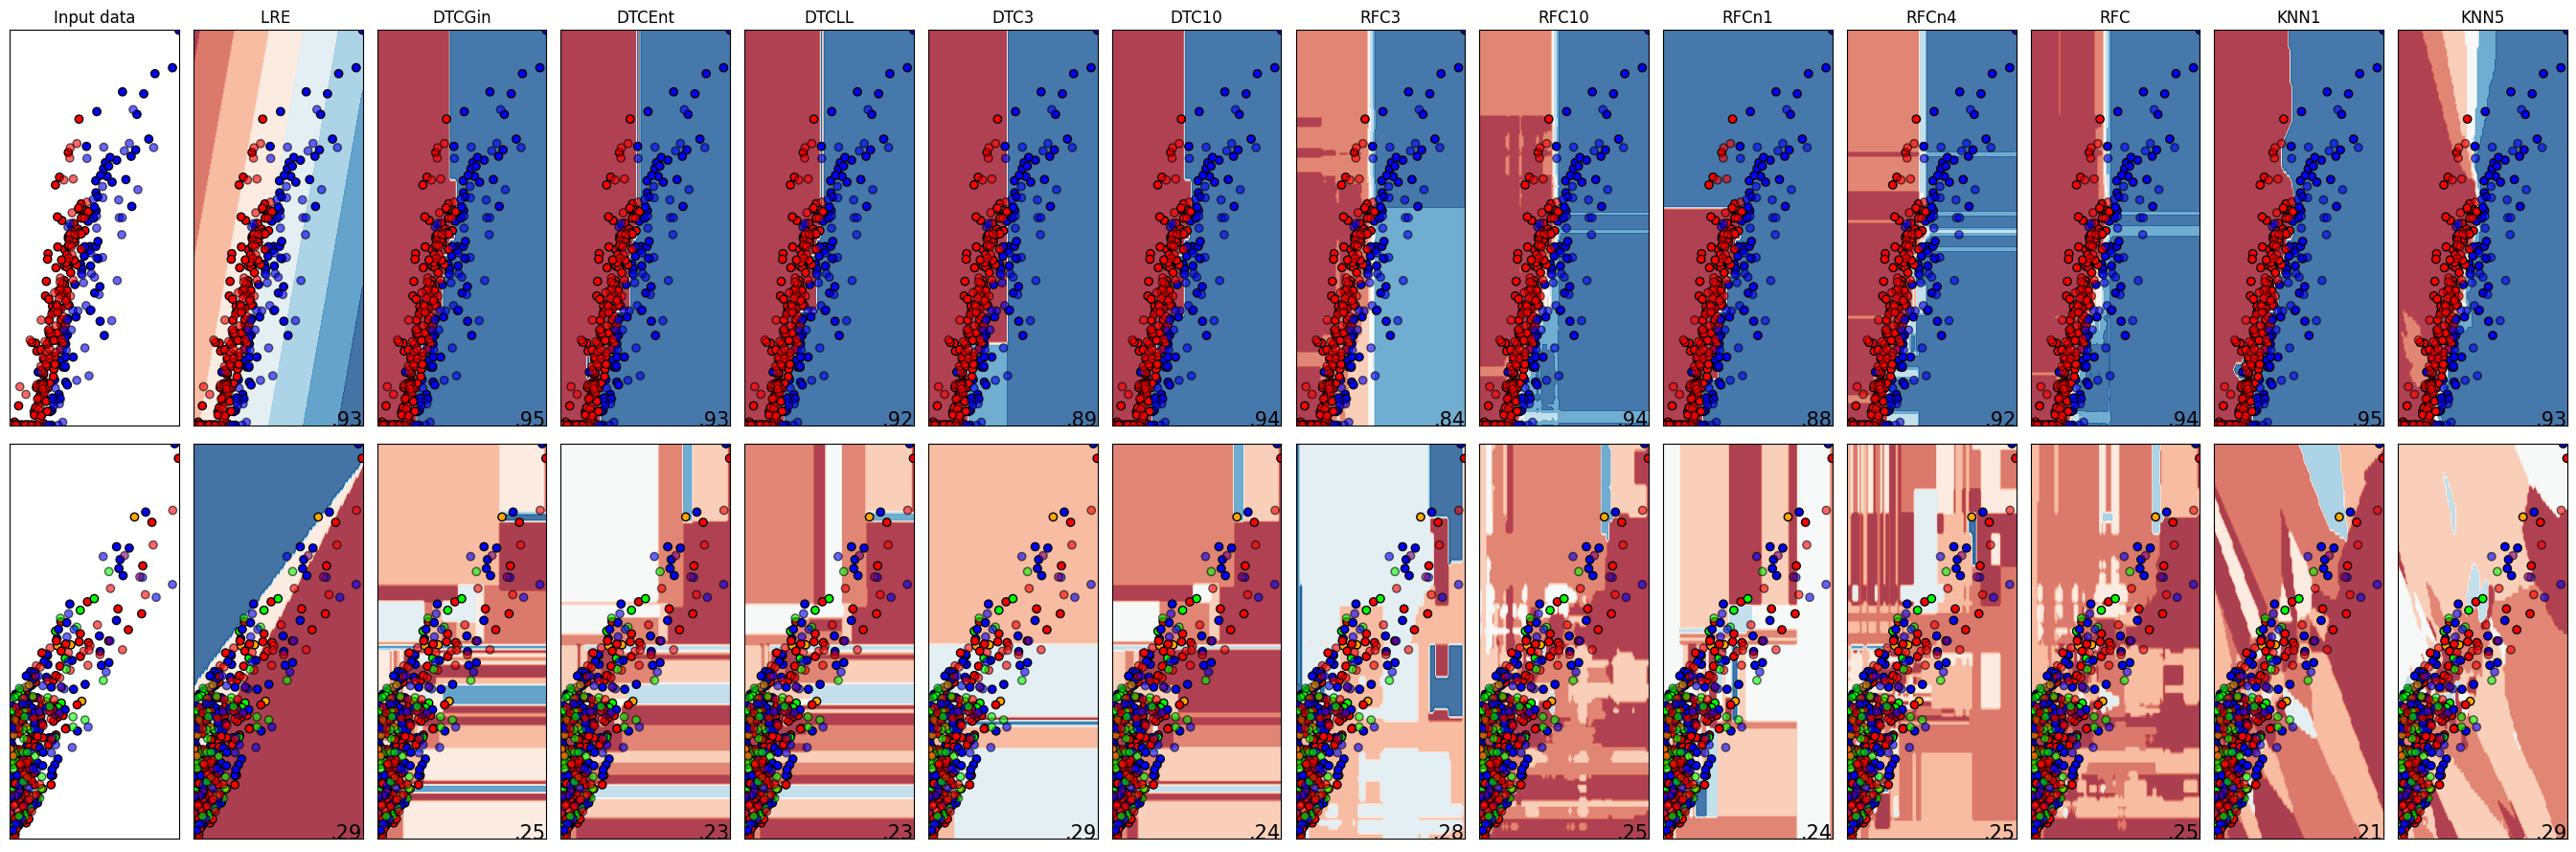

In [8]:
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    y, X = ds
    if len(X) != len(y):
        raise ValueError(f"Inconsistent number of samples in X and y: {len(X)} != {len(y)}")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    if ds_cnt == 0:
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    else :
        # Kolory dla 3+ klas
        cm_bright = ListedColormap(["#FF0000", "#0000FF", "#00FF00", "#FFA500", "#800080"])

    ax = plt.subplot(len(datasets), len(models) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in models:
        ax = plt.subplot(len(datasets), len(models) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()